# RecoGym Bandit Based Popularity Agents

Action dict:
```
t    = time
u    = user
a    = action (int representing product in range(0, num_products) )
ps   = 1 / num_products
ps-a = array of probabilities (floats [0, 1]), 1 for every product
```

## BanditAgentA - Reinforcement like
Every product starts with uniform probability of getting recommended. 

1. Whenever a product is clicked, this probability increases significantly. (= reward)
2. Whenever a product is shown but not clicked, this probability decreases slightly. (= punishment)

Since multipliers are used, the second click on a product is rewarded more than the 1st click (assuming the first click brought it above uniform probability) Likewise, additional punishments will get smaller and smaller in absolute numbers.

In [2]:
import numpy as np
from random import choices
from recogym.agents import Agent

# Define an Agent class.
class BanditAgentA(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(BanditAgentA, self).__init__(config)

        self.product_weights = np.ones(self.config.num_products)
        self.factor_reward = 1.99
        self.factor_punish = 1.01


    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Reward good bandits, punish bad ones
        # This is identical to: 
        # 1 * 1.99**clicks * 1.01**-(views - clicks)
        if reward:
            if reward == 1:
                # Reward clicks
                self.product_weights[action['a']] *= self.factor_reward
            else:
                # Punish views without click
                self.product_weights[action['a']] /= self.factor_punish

            
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion to bandit feedback
        action = choices(range(self.config.num_products), weights=self.product_weights, k=1).pop()

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': self.product_weights[action] / sum(self.product_weights),
                'ps-a': self.product_weights / sum(self.product_weights)
            }
        }

/home/alp/.local/lib/python3.6/site-packages/recogym/agents/__init__.py:32: UserWarning: Agents Bandit MF Square, Organic MF Square and NN IPS are not available since torch cannot be imported. Install it with `pip install torch` and test it with `python -c "import torch"`
  warnings.warn('Agents Bandit MF Square, Organic MF Square and NN IPS are not available '


## BanditAgentB - Click-through rate based
Recommends based on frequency clicked vs frequency shown with a minimum (average) probability for those products that have never been shown. The "average" used is the median CTR of the RandomAgent. (~ 1.1450%)

In [1]:
import numpy as np
#from numpy.random import choice
from random import choices
from recogym.agents import Agent

# Define an Agent class.
class BanditAgentB(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(BanditAgentB, self).__init__(config)
        
        # Array: for every product store [# times viewed, #times clicked]
        self.bandit_stats = np.zeros((self.config.num_products, 2), dtype=int)


    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""
        # Store bandit stats if not organic
        if reward:
            # If there is not None, there was a view
            self.bandit_stats[action['a']][0] += 1
            
            # If reward == 1, there was a click
            self.bandit_stats[action['a']][1] += reward

            
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Transform stats into a click-through ratio (CTR) and make a recommendation where products with a
        # higher CTR also have a higher probability to get recommended.
        ctrs = [(0.011450 if views == 0 else clicks/views) for views,clicks in self.bandit_stats]
        
        # Recommend randomly, the higher the clicks/views ratio 
        action = choices(range(self.config.num_products), weights=ctrs, k=1).pop()

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ctrs[action] / sum(ctrs),
                'ps-a': ctrs / sum(ctrs)
            }
        }

ModuleNotFoundError: No module named 'recogym'

## Bandit Agent - Keeps track of number of clicks and recommendations

An agent that for each prodcut keeps track of number of recommendations and the number of clicks obtained. Recommendations are made based on thresholds for number of recommendations and number of clicks.

In [17]:
class BanditAgentRecFreq(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(BanditAgentRecFreq, self).__init__(config)

        self.product_weights = np.ones(self.config.num_products)
        self.recommend_freq = np.zeros((self.config.num_products, 2))
        self.factor_reward = 1.99
        self.factor_punish = 1.01

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""
        if action:
            self.recommend_freq[action["a"]][0] += 1
            
        # Reward good bandits, punish bad ones
        if reward:
            if reward == 1:
                self.product_weights[action["a"]] *= self.factor_reward
                self.recommend_freq[action["a"]][1] += 1
            else:
                self.product_weights[action["a"]] /= self.factor_punish

            
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion to bandit feedback
        action = choices(range(self.config.num_products), weights=self.product_weights, k=1).pop()
        
        recommend_freq_med = np.median(self.recommend_freq, axis=0)[0] #Threshold for number of recommendations
        num_click_med = np.median(self.recommend_freq, axis=0)[1] #Threshold for number of clicks
        
        if self.recommend_freq[action][0] > recommend_freq_med and self.recommend_freq[action][1] < num_click_med:
            self.product_weights[action] = 1
            action = choices(range(self.config.num_products), weights=self.product_weights, k=1).pop()
        
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': self.product_weights[action] / sum(self.product_weights),
                'ps-a': self.product_weights / sum(self.product_weights)
            }
        }

## Training the agents

In [18]:
import gym, recogym
from recogym import env_1_args, Configuration
from copy import deepcopy
from recogym.evaluate_agent import verify_agents, plot_verify_agents

env_1_args['random_seed'] = 42

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# Import the random agent.
from recogym.agents import RandomAgent, random_args

# Create the two agents.
num_products = env_1_args['num_products']
bandit_agent_a = BanditAgentA(Configuration(env_1_args))
bandit_agent_b = BanditAgentB(Configuration(env_1_args))
bandit_agent_rec = BanditAgentRecFreq(Configuration(env_1_args))
random_agent = RandomAgent(Configuration({
    **env_1_args,
    **random_args,
}))

# Train the bandit agent
num_offline_users = 1000
num_online_users = 1000
print(f'Training with {num_offline_users} users')
for useri in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        bandit_agent_a.train(old_observation, action, reward, done)
        bandit_agent_b.train(old_observation, action, reward, done)
        bandit_agent_rec.train(old_observation, action, reward, done)

Training with 1000 users


## Testing Agent Performance

In [19]:
# Verify the agents
env_1_args['random_seed'] = 42
new_env = gym.make('reco-gym-v1')
new_env.init_gym(env_1_args)
result = verify_agents(new_env,
                       num_online_users,
                       {
                           'CTR Bandit': bandit_agent_b,
                           'Reinforcement Bandit': bandit_agent_a,
                           'Random agent': random_agent,
                           'Recommendation based': bandit_agent_rec
                       })
print(result)

                  Agent     0.025     0.500     0.975
0            CTR Bandit  0.011072  0.011804  0.012567
1  Reinforcement Bandit  0.014033  0.014865  0.015729
2          Random agent  0.010818  0.011548  0.012311
3  Recommendation based  0.014020  0.014852  0.015716


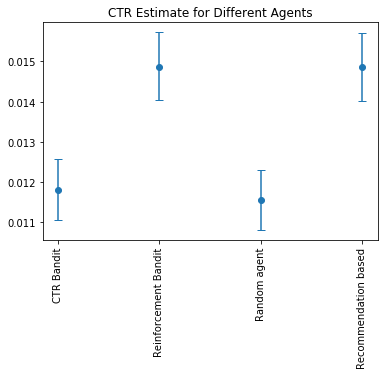

In [20]:
import matplotlib.pyplot as plt
fig = plot_verify_agents(result)
plt.show()

# Older work (tests, tuning, ...)

### Results (manual)
reward - punishment - scores
```
1.50 - 1.50 - (0.013994055869064171, 0.013171884239367734, 0.014849254638899079)
1.75 - 1.25 - (0.014003945889044578, 0.013182341474947828, 0.0148585063756147)
1.99 - 1.01 - (0.014008953966975324, 0.01318705769572728,  0.014863817756372355)
1.01 - 1.01 - (0.011521147715471919, 0.010782573106312417, 0.012292302808081579)
2.00 - 2.00 - (0.013989690193723066, 0.013168154951966047, 0.014844211295086618)
1.50 - 1.00 - (0.013942676922602393, 0.013123122930160163, 0.014795171507556604)
1.95 - 1.05 - (0.013978205368534297, 0.01315734006691718,  0.014832030229353088)
3.00 - 1.10 - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)
1.98 - 1.01 - (0.01397922984435104, 0.013158685574726737, 0.014832704827731802)
```

## Hyperparameter tuning (how much to reward / punish)

In [181]:
import gym, recogym
from recogym import env_1_args, Configuration
from copy import deepcopy

env_1_args['random_seed'] = 42
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

num_products = env_1_args['num_products']
bandit_agent_a = BanditAgentA(Configuration(env_1_args))

parameters = [
    (1.50, 1.50),
    (1.75, 1.25),
    (1.99, 1.01),
    (1.98, 1.02),
    (1.01, 1.01),
    (2.00, 2.00),
    (1.50, 1.00),
    (1.95, 1.05),
    (3.00, 1.10),
    (5.00, 2.00),
    (5.00, 1.00)
]
results = {}

for reward, punish in parameters:
    # Set reward & punish parameters
    bandit_agent_a.factor_reward = reward
    bandit_agent_a.factor_punish = punish
    
    # Run tests
    result = recogym.test_agent(deepcopy(env), deepcopy(bandit_agent_a), 1000, 1000)
    results[(reward, punish)] = result

Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (17.25397825241089s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (19.518059492111206s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (19.082467079162598s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (18.70867395401001s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (19.223085641860962s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (19.28720259666443s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (18.157710075378418s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (17.238532543182373s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (17.084410190582275s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (17.368014812469482s)
Start: Agent Training #0
Start: Agent Testing #0
End: Agent Testing #0 (1

In [183]:
for k, v in results.items():
    print(f'{k} - {v}')

best_median = None
for m,_,_ in results.values():
    if best_median is None or m > best_median:
        best_median = m

print("\nBest result (only median is shown):")
for k,v in results.items():
    if v[0] == best_median:
        print(f'{k} - {v[0]}')

(1.5, 1.5) - (0.013887907208452902, 0.013069263722806184, 0.014739553504537817)
(1.75, 1.25) - (0.014007542089064936, 0.013186108590391916, 0.014861908743926122)
(1.99, 1.01) - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)
(1.98, 1.02) - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)
(1.01, 1.01) - (0.011269686199074699, 0.010536946831149873, 0.012035238546886817)
(2.0, 2.0) - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)
(1.5, 1.0) - (0.0139457378463552, 0.013125241616100644, 0.014799244346239915)
(1.95, 1.05) - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)
(3.0, 1.1) - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)
(5.0, 2.0) - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)
(5.0, 1.0) - (0.013978205368534297, 0.01315734006691718, 0.014832030229353088)

Best result (only median is shown):
(1.75, 1.25) - 0.014007542089064936
